### ITR BENCHMARK (Parametric)



---
---
Florie Brion Bouvier<br>
Etienne Peyrot<br>
Alan Balendran<br>



1. [Dataset](#part1)
1. [S Learner](#part2)
1. [T Learner](#part3)
1. [X Learner](#part4)
1. [Comparison](#part5)

To do:

- [x] R Learner
- [x] Add splines (perhaps Florie/Etienne can do it on R)
- [x] Heatmap 


In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random

import statsmodels.api as sm
import sklearn
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.calibration import calibration_curve
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score 



# a voir
from matplotlib.figure import Figure
from IPython.display import Image

from tabulate import tabulate

In [2]:
## set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)

## Dataset <a id="part1"></a>

In [3]:
file_name = 'data/ist-imp.csv'
file_path = '/content/ist-imp.csv'

if not os.path.isfile(file_path) :
    try :
        # upload file for colab user
        from google.colab import files
        uploaded = files.upload()
    except :
        pass

data = pd.read_csv(file_name)

data = data.drop('heparin',axis=1) # Don't need Heparin
hosp_num = data['HOSPNUM'] # will be used to create independent train/test split
data = data.drop('HOSPNUM',axis=1)

In [4]:
data.head(3)

,AGE,RDELAY,SBP,SEX,CTbeforeHosp,CTInfarct,AtrialFib,Asp3d,FaceDef,ArmHandDef,...,Dysphasia,Hemianopia,VSDisorder,CerebSigns,OtherDeficit,Conscious,StrokeType,region,aspirin,deathdep
0,69,17,140,M,Yes,Yes,No,No,No,No,...,Yes,No,Yes,No,Yes,Drowsy,PACS,Europe,1,1
1,76,10,150,M,Yes,No,No,No,Yes,Yes,...,No,No,No,No,No,Fully alert,LACS,Europe,0,1
2,71,43,170,F,Yes,No,No,No,Yes,Yes,...,No,No,No,No,No,Fully alert,LACS,Europe,1,1


**21** variables:<br>
- 19 covariables: ` AGE `,` RDELAY `,` SBP `,` SEX `,` CTbeforeHosp `,` CTInfarct `,` AtrialFib `,` Asp3d `,<br>` FaceDef `,` ArmHandDef `,` LegFootDef `,` Dysphasia `,` Hemianopia `,` VSDisorder `,<br>` CerebSigns `,` OtherDeficit `,` Conscious `,` StrokeType `,` region `
- treatment: `aspirin`
- outcome: `deathdep`

In [5]:
continuous_col = [] 
categorical_col = []

for c in data.columns:
    if data[c].dtype=='object' or c in ['aspirin', 'deathdep']:
        data[c] = data[c].astype('category') ## convert as category
        categorical_col.append(c)
    else:
        continuous_col.append(c)

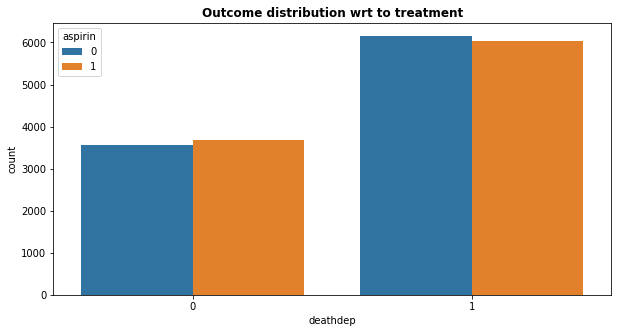

In [6]:
plt.figure(figsize=(10,5))
sns.countplot(data=data, x='deathdep', hue='aspirin')
plt.title('Outcome distribution wrt to treatment', fontweight='bold', fontsize=12);

In [7]:
def preprocessing (data, collins_format:bool = True, interaction_feature:bool = True) :
    df = data.copy()

    if collins_format :
        # get the categorical covariates name
        to_dummies = []
        for c in categorical_col:
            if df[c].nunique()>2:
                to_dummies.append(c)
        
        # drop the reference values (see Collins paper) 
        reference_to_drop = [
            'FaceDef_No',
            'ArmHandDef_No',
            'LegFootDef_No',
            'Dysphasia_No',
            'Hemianopia_No',
            'VSDisorder_No',
            'CerebSigns_No',
            'OtherDeficit_No',
            'Conscious_Fully alert',
            'StrokeType_PACS',
            'region_Europe'
        ]

        # transform categorical covariates into binary covariates
        df_dummies = pd.get_dummies(df[to_dummies])
        df_dummies = df_dummies.drop(reference_to_drop, axis=1)

        to_encode = set(categorical_col)-set(to_dummies)
        df = pd.concat([df,df_dummies], axis=1)
        df = df.drop(to_dummies, axis=1)

        lab_encoder = LabelEncoder() ##encoding categorical features
        for c in to_encode: ## change with to_encode if using dummies
            df[c] = lab_encoder.fit_transform(df[c])
        
    else :
        lab_encoder = LabelEncoder() ##encoding categorical features
        for c in categorical_col: ## change with to_encode if using dummies
            df[c] = lab_encoder.fit_transform(df[c])
    
    no_interaction_covariates = list(df.columns.drop(['aspirin', 'deathdep']))

    if interaction_feature :
        # add treatment interaction with covariates 
        features = no_interaction_covariates
        X_interaction = df[features].mul(df['aspirin'],axis=0)
        X_interaction.columns = [s+'_treatment' for s in X_interaction.columns]
        df = pd.concat([df,X_interaction],axis=1)
    
    # add intercept
    df['intercept'] = 1
    no_interaction_covariates = ['intercept'] + no_interaction_covariates

    return df, no_interaction_covariates

Splitting into train/test by making sure that we do not have the same hospital numbers in both sets.

In [8]:
def data_splitting (df, seed=42) :
    gss = GroupShuffleSplit(n_splits=1, train_size=.66, random_state=seed)
    df_train = None
    df_test = None

    for tr_ind, te_ind in gss.split(df,groups=hosp_num):
        df_train = df.loc[tr_ind]
        df_test = df.loc[te_ind]
    
    return df_train, df_test

In [9]:
df, covariates_collins = preprocessing(data)
## the seed is choosen so that we end up with the same number of patients in the train/validation set as Collins
df_train, df_test = data_splitting(df, seed=4490)

X = df_train[covariates_collins]
treatment = df_train['aspirin']
y = df_train['deathdep']

# S learner <a id="part2"></a>

In [13]:
X_s = pd.concat([df_train.drop(['aspirin','deathdep'], axis=1), treatment], axis=1)
#X_s = pd.concat([X, treatment], axis=1)

## we will use the linear model from statsmodels
clf = sm.Logit(y, X_s).fit()


#clf = LinearRegression(fit_intercept=False, normalize=True)
#clf.fit(X_s, y)
#clf = RandomForestClassifier(n_estimators=250, max_depth=5).fit(X_s, y)
#clf.score(X_s, y)

# clf = LogisticRegression(fit_intercept=False, penalty='none', max_iter=500)
# clf.fit(X_s, y)

Optimization terminated successfully.
         Current function value: 0.519845
         Iterations 8


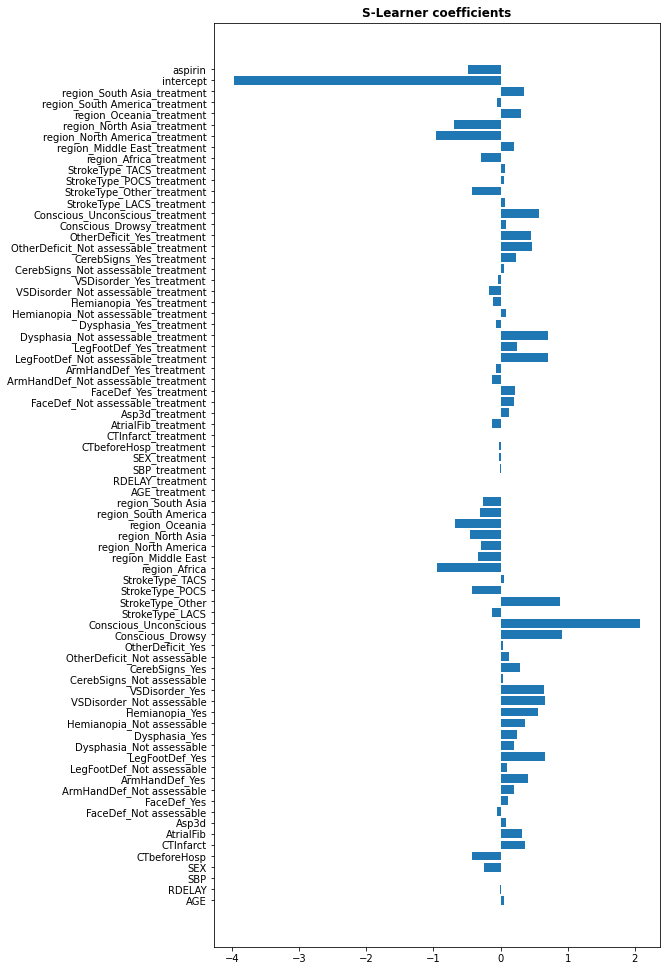

In [14]:
plt.figure(figsize=(8,17))
plt.barh(clf.params.index, clf.params.values);
plt.title('S-Learner coefficients', fontweight='bold', fontsize=12);

In [15]:
def discrimination_calibration_plot_sm(clf, training_set, validation_set, covariates=covariates_collins, target='deathdep', figsize=(15,5)):
    fig, ax = plt.subplots(1,2, figsize=figsize)    
    
    ## discrimination
    if isinstance(clf, sklearn.linear_model.LogisticRegression):
        
        plot_roc_curve(clf, training_set[covariates], training_set[target], name='Training', ax=ax[0])
        plot_roc_curve(clf, validation_set[covariates], validation_set[target], name='Validation', ax=ax[0]);

    else: 

        y_pred_train_proba = clf.predict(training_set[covariates])
        fpr_train, tpr_train, _ = roc_curve(training_set[target],  y_pred_train_proba)
        roc_auc_train = roc_auc_score(y_score=y_pred_train_proba, y_true=training_set[target])
        y_pred_val_proba = clf.predict(validation_set[covariates])
        fpr_val, tpr_val, _ = roc_curve(validation_set[target],  y_pred_val_proba)
        roc_auc_val = roc_auc_score(y_score=y_pred_val_proba, y_true=validation_set[target])

        ax[0].plot(fpr_train, tpr_train, label='Training (AUC = {:.2f})'.format(roc_auc_train))
        ax[0].plot(fpr_val, tpr_val, label='Validation (AUC = {:.2f})'.format(roc_auc_val))
        ax[0].legend()
        ax[0].set_ylabel('True Positive Rate')
        ax[0].set_xlabel('False Positive Rate')
        ax[0].set_title('Discrimination')
        
    ax[0].set_title('Discrimination')
    ## calibration curve
    prob_true, prob_pred = calibration_curve(validation_set[target], clf.predict(validation_set[covariates]), n_bins=5)
    
    ax[1].plot(prob_true, prob_pred, label='Validation')

    ax[1].set_title('Calibration')

    plt.legend(loc='upper left')

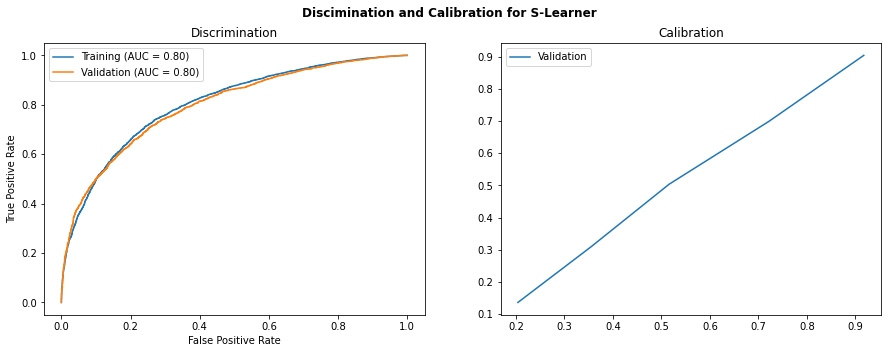

In [16]:
discrimination_calibration_plot_sm(clf, df_train, df_test, covariates=X_s.columns)
plt.suptitle('Discimination and Calibration for S-Learner', fontweight='bold', fontsize=12);

**Remark**: `predict_proba` returns both the proba *P(Y=0|X)* and *P(Y=1|X)* -> **[:, 1]** selects only *P(Y=1|X)*.

In [17]:
def ite_slearner(X) :
    X0 = X[X_s.columns].copy(); X0['aspirin'] = 0
    X1 = X[X_s.columns].copy(); X1['aspirin'] = 1
    if isinstance(clf, sklearn.linear_model.LogisticRegression):
        return clf.predict_proba(X1)[:, 1] - clf.predict_proba(X0)[:, 1]
    else:
        return clf.predict(X1) - clf.predict(X0)

ite_slearner(df_test.iloc[[1]])

25   -0.086001
dtype: float64

# T learner <a id="part3"></a>

In [18]:
X_0, y_0 = X.loc[treatment==0], y.loc[treatment==0]
X_1, y_1 = X.loc[treatment==1], y.loc[treatment==1]

mu_0 = sm.Logit(y_0, X_0).fit()
mu_1 = sm.Logit(y_1, X_1).fit()

#mu_0 = LogisticRegression(fit_intercept=False, penalty='none', max_iter=1000)
#mu_1 = LogisticRegression(fit_intercept=False, penalty='none', max_iter=1000)
#mu_0.fit(X_0, y_0)
#mu_1.fit(X_1, y_1);


Optimization terminated successfully.
         Current function value: 0.525489
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.514298
         Iterations 8


In [19]:
def table_oddratio(clf):
    table = pd.concat([np.exp(clf.params).round(2), clf.conf_int(0.05).apply(np.exp).round(2), clf.pvalues.round(3)],
        axis=1)
    table.columns = ['Odd_ratio', 'lower', 'upper', 'P']
    table['Odd ratio (95%CI)'] = table['Odd_ratio'].map(str) + " (" + table['lower'].map(str) + '-' +  table['upper'].map(str)+ ')'
    return table


In [20]:
with_aspirin = table_oddratio(mu_1)
without_aspirin = table_oddratio(mu_0)

summary_table = pd.concat([with_aspirin[['Odd ratio (95%CI)', 'P']], without_aspirin[['Odd ratio (95%CI)', 'P']]],
                          keys=['With aspirin', 'Without aspirin'], axis=1)

In [21]:
summary_table

With aspirin           Without aspirin  \
                             Odd ratio (95%CI)      P  Odd ratio (95%CI)   
intercept                     0.01 (0.01-0.02)  0.000   0.02 (0.01-0.03)   
AGE                           1.05 (1.05-1.06)  0.000   1.05 (1.04-1.05)   
RDELAY                          1.0 (1.0-1.01)  0.148     1.0 (0.99-1.0)   
SBP                              1.0 (1.0-1.0)  0.041      1.0 (1.0-1.0)   
SEX                           0.76 (0.67-0.86)  0.000   0.78 (0.69-0.89)   
CTbeforeHosp                  0.64 (0.55-0.74)  0.000   0.65 (0.56-0.76)   
CTInfarct                     1.45 (1.25-1.68)  0.000   1.43 (1.24-1.66)   
AtrialFib                     1.21 (1.02-1.44)  0.032   1.38 (1.15-1.67)   
Asp3d                         1.23 (1.06-1.43)  0.006   1.08 (0.93-1.25)   
FaceDef_Not assessable        1.15 (0.52-2.58)  0.729   0.94 (0.45-1.97)   
FaceDef_Yes                     1.38 (1.2-1.6)  0.000   1.11 (0.96-1.28)   
ArmHandDef_Not assessable     1.07 (0.35-3.28)  0.910   1.21 (0.41-3.58)   
ArmHandDef_Yes                1.41 (1.13-1.77)  0.003   1.51 (1.21-1.89)   
LegFootDef_Not assessable     2.23 (1.04-4.79)  0.040    1.1 (0.51-2.39)   
LegFootDef_Yes                2.47 (2.07-2.95)  0.000   1.94 (1.63-2.31)   
Dysphasia_Not assessable      2.51 (1.25-5.03)  0.009   1.23 (0.73-2.08)   
Dysphasia_Yes                 1.19 (1.01-1.41)  0.040    1.27 (1.08-1.5)   
Hemianopia_Not assessable      1.57 (1.2-2.05)  0.001    1.45 (1.1-1.91)   
Hemianopia_Yes                 1.56 (1.2-2.02)  0.001   1.74 (1.34-2.26)   
VSDisorder_Not assessable     1.62 (1.26-2.08)  0.000    1.92 (1.48-2.5)   
VSDisorder_Yes                 1.85 (1.49-2.3)  0.000   1.92 (1.54-2.38)   
CerebSigns_Not assessable      1.1 (0.78-1.54)  0.601   1.04 (0.75-1.45)   
CerebSigns_Yes                1.67 (0.62-4.51)  0.309   1.34 (0.54-3.31)   
OtherDeficit_Not assessable   1.79 (1.19-2.72)  0.006   1.13 (0.77-1.64)   
OtherDeficit_Yes              1.65 (1.26-2.15)  0.000    1.04 (0.8-1.35)   
Conscious_Drowsy               2.71 (2.22-3.3)  0.000   2.49 (2.04-3.04)   
Conscious_Unconscious        14.0 (2.81-69.81)  0.001  7.93 (2.24-28.07)   
StrokeType_LACS               0.94 (0.77-1.15)  0.531   0.88 (0.72-1.07)   
StrokeType_Other              1.59 (0.58-4.34)  0.370   2.44 (0.89-6.68)   
StrokeType_POCS               0.69 (0.26-1.85)  0.464   0.65 (0.27-1.61)   
StrokeType_TACS               1.13 (0.85-1.48)  0.400   1.05 (0.79-1.38)   
region_Africa                  0.29 (0.12-0.7)  0.006   0.39 (0.17-0.88)   
region_Middle East            0.87 (0.58-1.31)  0.512   0.72 (0.49-1.07)   
region_North America            0.28 (0.1-0.8)  0.017   0.75 (0.35-1.61)   
region_North Asia             0.32 (0.13-0.75)  0.009   0.63 (0.32-1.27)   
region_Oceania                0.69 (0.54-0.88)  0.003    0.51 (0.4-0.65)   
region_South America           0.7 (0.52-0.93)  0.014   0.73 (0.55-0.98)   
region_South Asia             1.09 (0.72-1.65)  0.685   0.77 (0.51-1.15)   

                                    
                                 P  
intercept                    0.000  
AGE                          0.000  
RDELAY                       0.734  
SBP                          0.458  
SEX                          0.000  
CTbeforeHosp                 0.000  
CTInfarct                    0.000  
AtrialFib                    0.001  
Asp3d                        0.309  
FaceDef_Not assessable       0.876  
FaceDef_Yes                  0.159  
ArmHandDef_Not assessable    0.726  
ArmHandDef_Yes               0.000  
LegFootDef_Not assessable    0.811  
LegFootDef_Yes               0.000  
Dysphasia_Not assessable     0.441  
Dysphasia_Yes                0.004  
Hemianopia_Not assessable    0.008  
Hemianopia_Yes               0.000  
VSDisorder_Not assessable    0.000  
VSDisorder_Yes               0.000  
CerebSigns_Not assessable    0.812  
CerebSigns_Yes               0.528  
OtherDeficit_Not assessable  0.531  
OtherDeficit_Yes             0.

In [22]:
#t_learner_feat_importance = pd.DataFrame({
#    'Features': X_0.columns,
#    'Control': mu_0.coef_[0],
#    'Treated': mu_1.coef_[0],
#    }).set_index('Features')

In [23]:
#t_learner_feat_importance.plot.barh(figsize=(13,14));
#plt.title('T-learner feature importance');

**Control group**

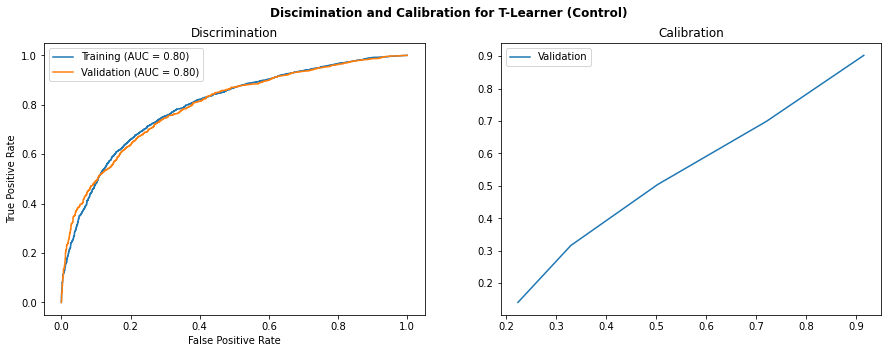

In [22]:
discrimination_calibration_plot_sm(mu_0, pd.concat([X_0, y_0],axis=1),df_test.loc[df_test['aspirin']==0], covariates=X_0.columns)
plt.suptitle('Discimination and Calibration for T-Learner (Control)', fontweight='bold', fontsize=12);

**Treated group**

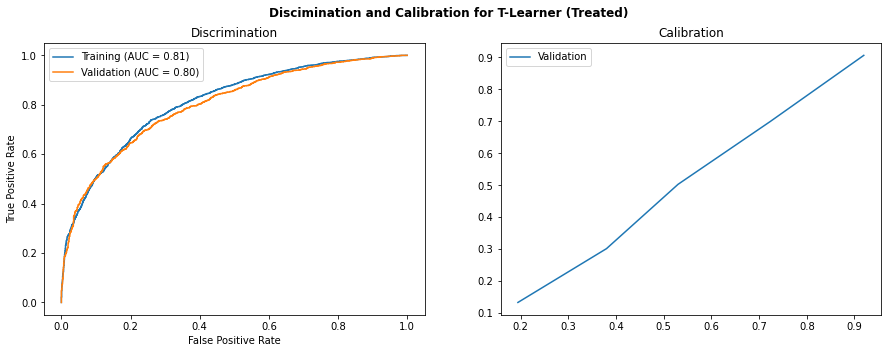

In [23]:
discrimination_calibration_plot_sm(mu_1, pd.concat([X_1, y_1],axis=1),df_test.loc[df_test['aspirin']==1], covariates=X_1.columns)
plt.suptitle('Discimination and Calibration for T-Learner (Treated)', fontweight='bold', fontsize=12);

In [24]:
def ite_tlearner(X) :
    X = X[X_0.columns]
    if isinstance(clf, sklearn.linear_model.LogisticRegression):
        return mu_1.predict_proba(X)[:,1] - mu_0.predict_proba(X)[:,1]
    else:
        return mu_1.predict(X) - mu_0.predict(X)


## X-learner <a id="part4"></a>

**Estimating the propensity score**

In [25]:
average_propensity_score = cross_val_score(LogisticRegression(penalty='none', max_iter=1000), df_train[covariates_collins], df_train['aspirin'], cv=5)
print(average_propensity_score.mean())

0.48769664832983606


In [26]:
if isinstance(clf, sklearn.linear_model.LogisticRegression):
    D_1 = np.array(y_1) - mu_0.predict_proba(X_1)[:,1] 
    D_0 = mu_1.predict_proba(X_0)[:,1] - np.array(y_0)
else:
    D_1 = np.array(y_1) - mu_0.predict(X_1)
    D_0 = mu_1.predict(X_0) - np.array(y_0)

tau_0 = LinearRegression() ## linear regression because the target is no longer binary
tau_1 = LinearRegression()

tau_0.fit(X_0, D_0)
tau_1.fit(X_1, D_1);

g_x = 0.5 
def ite_xlearner(X) :
    X = X[X_0.columns]
    return tau_0.predict(X)*g_x + (1-g_x)*tau_1.predict(X)

In [27]:
x_learner_feat_importance = pd.DataFrame({
    'Features': X_0.columns,
    'Control': tau_0.coef_,
    'Treated': tau_1.coef_
    }).set_index('Features')

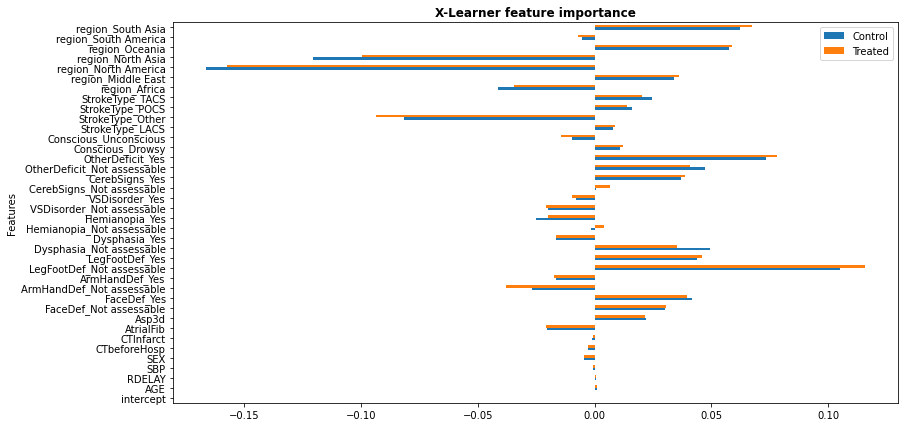

In [28]:
x_learner_feat_importance.plot.barh(figsize=(13,7));
plt.title('X-Learner feature importance',  fontweight='bold', fontsize=12);

## Comparison <a id="part5"></a>

In [29]:
df_test['ITE S-learner'] = ite_slearner(df_test)
df_test['ITE T-learner'] = ite_tlearner(df_test)
df_test['ITE X-learner'] = ite_xlearner(df_test)
df_test['ITR S-learner'] = df_test['ITE S-learner'].apply(lambda x: 0 if x>0 else 1)
df_test['ITR T-learner'] = df_test['ITE T-learner'].apply(lambda x: 0 if x>0 else 1)
df_test['ITR X-learner'] = df_test['ITE X-learner'].apply(lambda x: 0 if x>0 else 1)

In [30]:
ite_values = df_test[['ITE S-learner', 'ITE T-learner', 'ITE X-learner']].melt()
ite_values.columns = ['Model', 'ITE']

In [ ]:
5 splits et 5 répétitions.

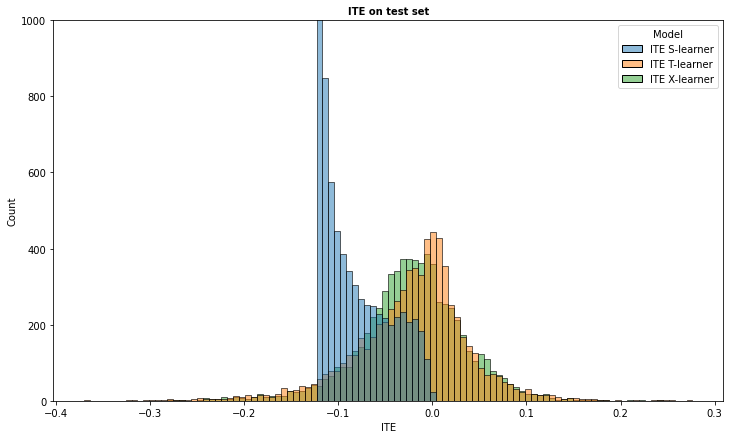

In [31]:
plt.figure(figsize=(12, 7))
plt.ylim([0, 1000]);
sns.histplot(data=ite_values, x='ITE', hue='Model')
plt.title('ITE on test set', fontweight='bold', fontsize=10);

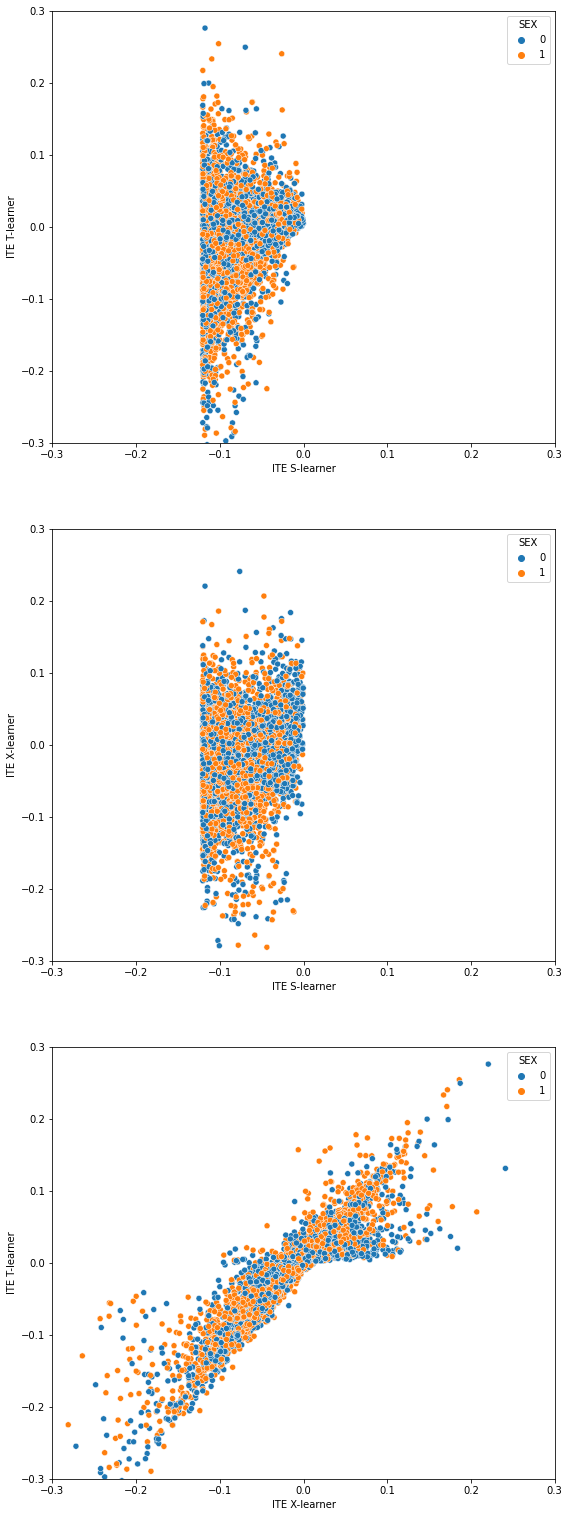

In [33]:
fig, ax = plt.subplots(3,1, figsize=(9, 27))    
plt.setp(ax, xlim=[-0.3, 0.3], ylim=[-0.3, 0.3])
hue = 'SEX'

sns.scatterplot(data=df_test, x="ITE S-learner", y="ITE T-learner",hue=hue, ax=ax[0])
sns.scatterplot(data=df_test, x="ITE S-learner", y="ITE X-learner",hue=hue, ax=ax[1])
sns.scatterplot(data=df_test, x="ITE X-learner", y="ITE T-learner",hue=hue, ax=ax[2]);

#### Computing V(r)

In [34]:
def V(df,*, ite=None, itr=None, trt: str = 'aspirin', outcome: str = 'deathdep') :
    assert not (isinstance(ite, type(None)) and isinstance(itr, type(None)))
    
    if isinstance(itr, type(None)) : itr = (ite(df) < 0) if callable(ite) else (ite < 0)
    elif callable(itr) : itr = itr(df)
    treatment_rule_concordance = df.loc[df[trt]==itr]

    return treatment_rule_concordance[outcome].mean()

def SMD(df,*, ite=None, itr=None, trt: str = 'aspirin', outcome: str = 'deathdep',
        welch_test: bool = False) :
    assert not ((ite is None) and (itr is None))
    
    if itr is None : itr = (ite(df) < 0) if callable(ite) else (ite < 0)
    elif callable(itr) : itr = itr(df)
    match_idx = df[trt]==itr
    df_match = df.loc[match_idx]
    try :
        mean_diff = df_match.loc[(itr[match_idx]==1), outcome].mean() - df_match.loc[itr[match_idx]==0, outcome].mean()
        if not welch_test : return mean_diff / np.sqrt(df_match[outcome].var())
        # compute Welch t-test statistic 
        var0 = df_match.loc[itr[match_idx]==1, outcome].var() / len(df_match.loc[itr[match_idx]==1])
        var1 = df_match.loc[itr[match_idx]==0, outcome].var() / len(df_match.loc[itr[match_idx]==0])
        return mean_diff / np.sqrt(var0 + var1)
    except :
        return np.NaN

In [35]:
# ITR Probability
print('Prob(itr S learner) = %.2f' %df_test['ITR S-learner'].mean())
print('Prob(itr T learner) = %.2f' %df_test['ITR T-learner'].mean())
print('Prob(itr X learner) = %.2f' %df_test['ITR X-learner'].mean())

# Average outcome for itr on training set
print('\nV(itr S learner) tr = %.2f' %V(df_train, ite=ite_slearner))
print('V(itr T learner) tr = %.2f' %V(df_train, ite=ite_tlearner))
print('V(itr X learner) tr = %.2f' %V(df_train, ite=ite_xlearner))

# Average outcome for itr on testing set
print('\nV(itr S learner) te = %.2f' %V(df_test, ite=ite_slearner))
print('V(itr T learner) te = %.2f' %V(df_test, ite=ite_tlearner))
print('V(itr X learner) te = %.2f' %V(df_test, ite=ite_xlearner))

Prob(itr S learner) = 1.00
Prob(itr T learner) = 0.63
Prob(itr X learner) = 0.67

V(itr S learner) tr = 0.61
V(itr T learner) tr = 0.60
V(itr X learner) tr = 0.59

V(itr S learner) te = 0.65
V(itr T learner) te = 0.65
V(itr X learner) te = 0.65


#### Ploting Table

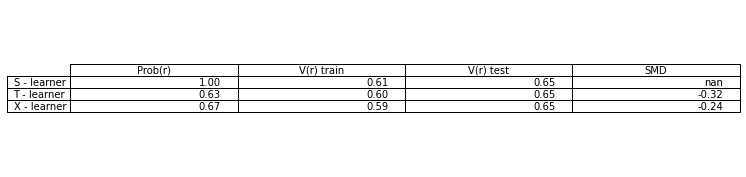

In [36]:
ite_learner = [ite_slearner, ite_tlearner, ite_xlearner]

fig, ax = plt.subplots(figsize=(12,3))

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

df = pd.DataFrame()
df['Prob(r)'] = [np.mean(ite(df_test)<0) for ite in ite_learner]
df['V(r) train'] = [V(df_train, ite=ite) for ite in ite_learner]
df['V(r) test'] = [V(df_test, ite=ite) for ite in ite_learner]
df['SMD'] = [SMD(df_test, ite=ite) for ite in ite_learner]

df.update(df.applymap('{:,.2f}'.format))

ax.table(cellText=df.values, colLabels=df.columns, loc='center',
         rowLabels=['S - learner', 'T - learner', 'X - learner']);

#### Ploting comparison ITR and significant covariates

### Table to compare ITRs and covariates influence

In [37]:
list_itr = [lambda x : ite_slearner(x) < 0,
            lambda x : ite_tlearner(x) < 0,
            lambda x : ite_xlearner(x) < 0]
itr_name = ['S learner', 'T learner', 'X learner']

def plot_tabular (df, list_itr, itr_name, tablefmt='simple', pandas_display=False) :
    header = ['covariates']
    for s in itr_name : header += [s + ' ctrl'] + [s + ' trt']
    Mat = [] 
    for c in covariates_collins :
        row = [c]
        for itr in list_itr :
            itr1 = itr(df)
            itr0 = [not b for b in itr1]
            row.append(df.loc[itr0, c].mean())
            row.append(df.loc[itr1, c].mean())
        Mat.append(row)
    if pandas_display:
        df_pandas = pd.DataFrame(Mat,columns=header)
        df_pandas = df_pandas.set_index('covariates')
        display(df_pandas.round(3))
    else:
        print(tabulate(Mat, headers=header, floatfmt=".3f", tablefmt=tablefmt))

In [38]:
plot_tabular(df_test, list_itr, itr_name, pandas_display=True)

,S learner ctrl,S learner trt,T learner ctrl,T learner trt,X learner ctrl,X learner trt
covariates,,,,,,
intercept,NaN,1.000,1.000,1.000,1.000,1.000
AGE,NaN,72.294,75.036,70.667,74.579,71.179
RDELAY,NaN,19.842,22.665,18.167,23.433,18.091
SBP,NaN,160.048,152.998,164.231,151.956,163.994
SEX,NaN,0.535,0.492,0.561,0.498,0.554
CTbeforeHosp,NaN,0.640,0.669,0.624,0.674,0.624
CTInfarct,NaN,0.314,0.374,0.279,0.365,0.290
AtrialFib,NaN,0.176,0.158,0.186,0.141,0.192
Asp3d,NaN,0.228,0.317,0.175,0.329,0.179


#### Ploting comparison ITR given covariates levels

In [42]:
#sns.choose_diverging_palette()

In [43]:
#sns.palplot(sns.diverging_palette(7, 263, s=99, l=65, n=25))

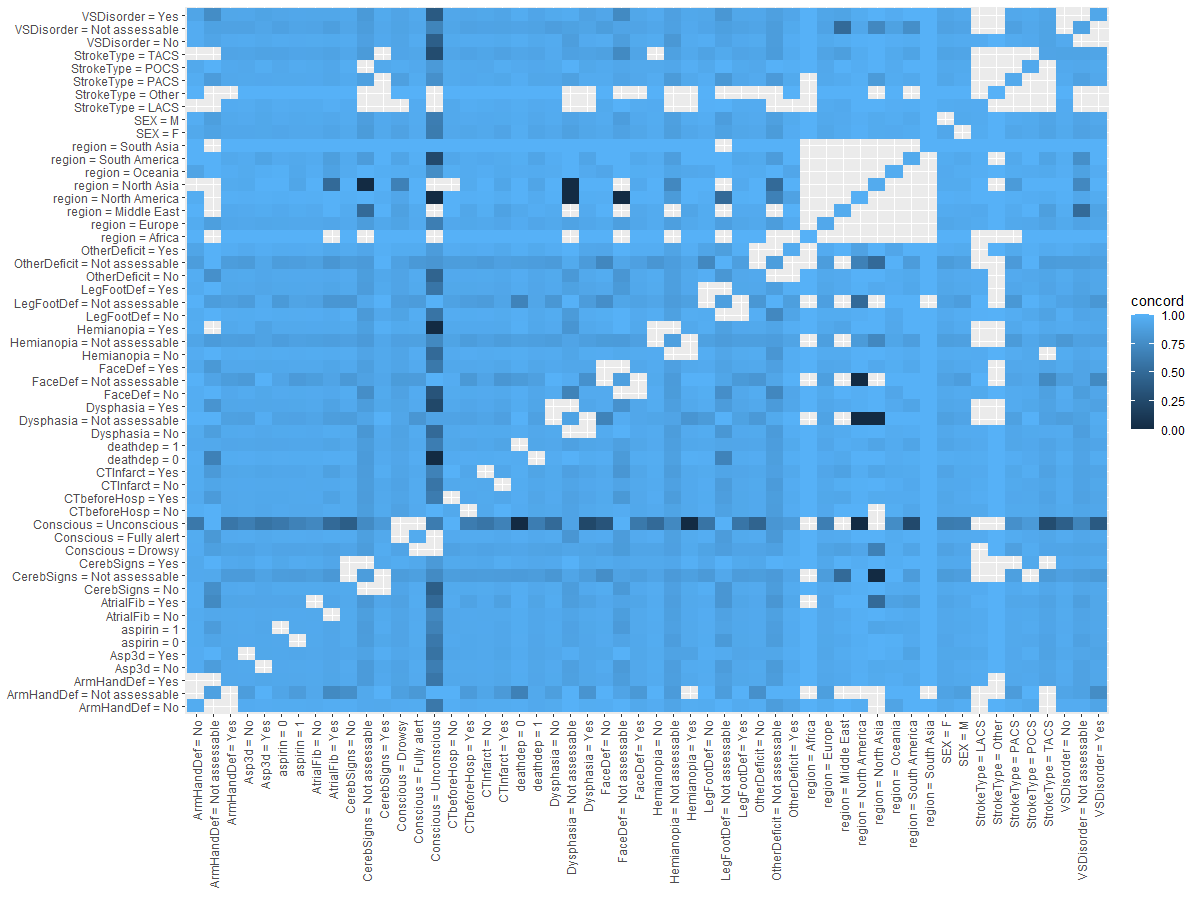

In [40]:
### La heatmap a été générée en R
Image(filename='results/heatmap.png') 